# 04、卷积神经网络
随着多层感知机的发展，有研究者不断的加深网络的深度，达到了1000多层的网络，但是效果不尽如人意，随着网络的深度增加，每一层的输出不断累乘，得到的数值将会越来越小（前提是不断乘小于1的权重），导致权重几乎不再更新，导致网络很难对数据进一步表征，同时我们知道全连接神经网络是稠密连接并且是权重不共享的，如果相邻的两层神经元为100，那么在计算的时候参数有100*100，随着网络的增加，计算成本急剧增加，所以一种稀疏连接权值共享的一种神经网络重回深度学习的舞台中央，那就是卷积神经网络。

## （1）卷积层
如果按照严格意义上的定义，卷积神经网络的卷积操作为互相关操作，如果将卷积核上下翻转左右翻转再与输入数据进行滑动窗口计算才叫做卷积运算，但是
>在机器学习中，学习算法会在核合适的位置学得恰当的值，所以一个基于核翻转的卷积运算的学习算法所学得的核，是对未进行翻转的算法学得的核
的翻转

所以本教程将这种互相关运算称作卷积运算,关于卷积的运算的更多细节请产看有关博客，如果有时间后期会在此处更新。
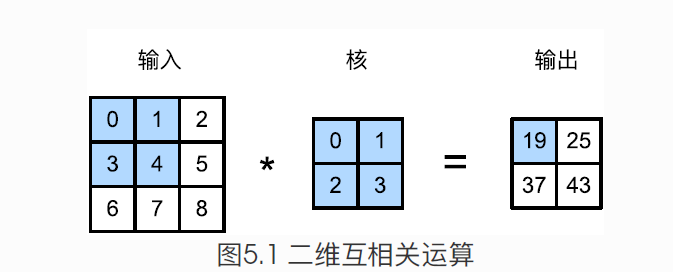

如上图所示，首先我们要有一个卷积核也称滤波器，然后我们从图像的左上角开始从左往右，进行滑动，当卷积核移动到某个位置时，图片的子图与卷积核按位相乘再求和作为输出的元素。

0x0+1x1+3x2+4x3=19

## （2）池化层
以此类推。笔者认为卷积操作的实质就是获取对卷积核响应高的元素，比如线条的响应，然后将获取到的特征进行组合获取更高维度的信息然后连接两层或多层全连接层进行分类，pooling层的提出是为了缓解卷积层对位置的过度敏感，
>最直接的作用是引入了不变性，比如最常见的conv-max pooling，因为取一片区域的最大值，所以这个最大值在该区域内无论在哪，max-pooling之后都是它，相当于对微小位移的不变性。而如果我们对输入pooling前的层做一些精心设计，让pooling region里对应的是设计后的一些性质变化，那么pooling就相当于实现了对这种设计出来的变化的不变性。比如旋转(当然就旋转而言这个方法似乎不是很好)

## （3）激活函数

激活函数的作用是判断有没有达到阈值。

放在人脸识别卷积神经网络中来思考，卷积层的激活函数的意义在于这一块区域的特征强度如果没有达到一定的标准，就输出0，表明这种特征提取方式（卷积核w）不能在该块区域提取到特征，或者说这块区域的这种特征很弱。由于输出0时，激活函数梯度几乎都为0，所以在特征很弱的区域，梯度几乎不下降，也就是说，和该特征无关的区域不会影响到该特征提取方式的训练。

反过来说，如果没有激活函数，就算特征很弱时，仍然可以得到输出，后面的层次继续把这个输出当成一个特征使用，这是不合理的。为了形象起见，我们做个比喻，本来我们可能希望在这个区域看到一个圆形，但是这里却是一个三角形，如果该三角形和我们期望看到的圆形形状相差很大的时候神经元的输出WX+B很小，我们就不希望输出值去衡量这个三角形有多不圆，而是希望输出这里没有一个圆形（对于分类问题而言，有多不圆对于我们的分类没有意义，因为我们是通过了解到形状的组合来判定人脸属于哪一类，验证问题同理）。

卷积神经网络就是卷积层、池化层、激活函数作为基本单位不断地堆叠而成。



参考：https://www.zhihu.com/question/36686900/answer/68579066

https://blog.csdn.net/Fire_Light_/article/details/79542602

In [1]:
import torch
from torchvision import datasets
from torch import nn
from torchvision.transforms import transforms
import torch.optim as optim
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.ToTensor(),

])

trainset = datasets.MNIST(root='./data', train=True,
                          download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)


testset = datasets.MNIST(root='./data', train=False,
                         download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

## LeNet结构
![LeNet](https://static.oschina.net/uploads/space/2018/0311/012923_Ficx_876354.png)

|layer name|kernel size|output size|
-|-|-
输入层	|	32x32|
卷积层1|5x5|6x28x28
MaxPool1|2x2,stride=2|6x14x14
卷积层2|5x5|16x10x10
MaxPool2|2x2,stride=2|16x5x5
全连接层1|16x5x5|120
全连接层2|120|	84
输出层|84|10



参考：https://blog.csdn.net/daydayup_668819/article/details/79932548


https://blog.csdn.net/sunqiande88/article/details/80089941

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(     #input_size=(1*28*28)
            nn.Conv2d(1, 6, 5, 1, 2), #padding=2保证输入输出尺寸相同
            nn.ReLU(),      #input_size=(6*28*28)
            nn.MaxPool2d(kernel_size=2, stride=2),#output_size=(6*14*14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),      #input_size=(16*10*10)
            nn.MaxPool2d(2, 2)  #output_size=(16*5*5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    # 定义前向传播过程，输入为x
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # nn.Linear()的输入输出都是维度为一的值，所以要把多维度的tensor展平成一维
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## 模型构建
上面的cell构建了LeNet网络，按照图片层层构建即可。
### API 介绍
nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
nn.ReLU(inplace=True)
nn.MaxPool2d(kernel_size=3, stride=2)

- Conv2d是卷积层，API参数有：in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,bias=True, padding_mode='zeros'，输入形状、输出形状、卷积核大小、步长、填充、设定了取数之间的间隔、组卷积、计算时是否有b，常用是前五个和最后一个组卷积核和取数间隔复杂模型法可能会用到。

- nn.ReLU(inplace=True) 随机失活部分神经元，防止过拟合用的，inplace=True是优化内存的。

- nn.MaxPool2d 是池化层对F.max_pool2d的二次封装参数有，(input, kernel_size, stride,padding, dilation, ceil_mode,return_indices)
>kernel_size(int or tuple) - max pooling的窗口大小，可以为tuple，在nlp中tuple用更多，（n,1）
stride(int or tuple, optional) - max pooling的窗口移动的步长。默认值是kernel_size
padding(int or tuple, optional) - 输入的每一条边补充0的层数
dilation(int or tuple, optional) – 一个控制窗口中元素步幅的参数
return_indices - 如果等于True，会返回输出最大值的序号，对于上采样操作会有帮助
ceil_mode - 如果等于True，计算输出信号大小的时候，会使用向上取整，代替默认的向下取整的

- nn.AdaptiveAvgPool2d,全局平局pooling，对F.adaptive_avg_pool2d二次封装参数有：input、 output_size，输入特征图和输出的维度，他会自动根据输出维度设定步长和和大小进行pooling操作。

参考：https://blog.csdn.net/qq_40210472/article/details/87895626

In [3]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

In [4]:
# 在训练过程中一般一个轮次训练结束后对测试集整体进行测试，获取测试集上的损失和准确率
losses = []
acces = []
eval_losses = []
eval_acces = []
for e in range(epochs):
    train_loss = 0
    train_acc = 0
    model.train() 
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # loss.item()是平均损失，平均损失*batch_size=一次训练的损失
        train_loss += loss.item() * data.size(0)  
        _, pred = output.max(1)
        # 计算一个批次对了几个
        num_correct = (pred == target).sum().item()
        # 计算准确率=对的个数/批次大小
        acc = num_correct / data.shape[0]
        train_acc += acc
    # 统计一个轮次中平均损失与平均准确率
    losses.append(train_loss / len(trainloader.dataset))
    acces.append(train_acc / len(trainloader))
    eval_loss = 0
    eval_acc = 0
    model.eval() # 将模型改为预测模式
    with torch.no_grad():
        for im, label in testloader:
            out = model(im)
            loss = criterion(out, label)
            # 记录误差
            eval_loss += loss.item()
            # 记录准确率
            _, pred = out.max(1)
            num_correct = (pred == label).sum().item()
            acc = num_correct / im.shape[0]
            eval_acc += acc
        # 上面的代码对全部的测试集进行测试，下面两行就是讲这一次的整个测试集的损失和准确率存在列表里,如果进行可视化可能会用到
        eval_losses.append(eval_loss / len(testloader.dataset))
        eval_acces.append(eval_acc / len(testloader))
        print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
              .format(e, train_loss / len(trainloader), train_acc / len(trainloader), 
                     eval_loss / len(testloader), eval_acc / len(testloader)))

epoch: 0, Train Loss: 146.854156, Train Acc: 0.116488, Eval Loss: 2.280984, Eval Acc: 0.163515
epoch: 1, Train Loss: 95.301327, Train Acc: 0.589152, Eval Loss: 0.396333, Eval Acc: 0.883658
epoch: 2, Train Loss: 20.460910, Train Acc: 0.901486, Eval Loss: 0.217475, Eval Acc: 0.933718
epoch: 3, Train Loss: 13.123924, Train Acc: 0.936717, Eval Loss: 0.151756, Eval Acc: 0.954518
epoch: 4, Train Loss: 9.851324, Train Acc: 0.952958, Eval Loss: 0.118393, Eval Acc: 0.963475
epoch: 5, Train Loss: 7.869794, Train Acc: 0.962820, Eval Loss: 0.094910, Eval Acc: 0.969546
epoch: 6, Train Loss: 6.837644, Train Acc: 0.967717, Eval Loss: 0.085026, Eval Acc: 0.973527
epoch: 7, Train Loss: 5.960546, Train Acc: 0.971582, Eval Loss: 0.074164, Eval Acc: 0.976911
epoch: 8, Train Loss: 5.395046, Train Acc: 0.974047, Eval Loss: 0.067507, Eval Acc: 0.978702
epoch: 9, Train Loss: 4.896399, Train Acc: 0.976346, Eval Loss: 0.070963, Eval Acc: 0.977707


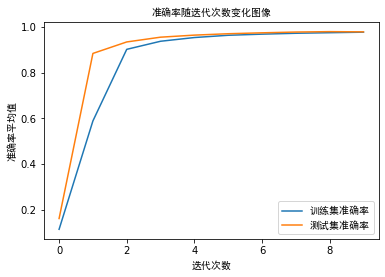

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
# acces
# eval_acces
myfont = FontProperties(fname='C:/Windows/Fonts/simhei.ttf')
h1, = plt.plot([x for x in range(len(acces))], acces, label="训练集准确率")
h2, = plt.plot([y for y in range(len(eval_acces))], eval_acces, label="测试集准确率")
plt.title('准确率随迭代次数变化图像', fontproperties=myfont)
plt.xlabel('迭代次数', fontproperties=myfont)
plt.ylabel('准确率平均值', fontproperties=myfont)
plt.legend(handles=[h1,h2],labels=['训练集准确率','测试集准确率'],prop=myfont)
plt.show()